
# iForestASD :  Unsupervised Anomaly Detection with Scikit-MultiFlow

An Implementation of Unsupervised Anomaly Detection with Isolation Forest in Scikit-MultiFlow with Sliding Windows \& drift detection


## References :

 - An Anomaly Detection Approach Based on Isolation Forest  for Streaming Data using Sliding Window (Ding \& Fei, 2013) https://www.sciencedirect.com/science/article/pii/S1474667016314999
 
 - Isolation-based Anomaly Detection (Liu, Ting \& Zhou, 2011) https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/tkdd11.pdf

 - Scikit MultiFlow HalfSpace Trees Implementation - “Fast anomaly detection for streaming data,” in IJCAI Proceedings - S.C.Tan, K.M.Ting, and T.F.Liu, 
 https://scikit-multiflow.github.io/scikit-multiflow/_autosummary/skmultiflow.anomaly_detection.HalfSpaceTrees.html#id2

 - Original implementation of Isolation Forest (not the one in SK-learn) https://github.com/Divya-Bhargavi/isolation-forest



# Notebook File Structure  is the following

Part 1 - Main Class contians
  - Init,
  - Partial_fit,
  -  Update_model,
  - Predict methods which use the anomaly_score methods of the iForest class

Part 2 - Isolation Forest class (re-used) and main functions
 - 

Part 3 - Testing some examples and comparison of HS-Trees and IsolatationForestStream 
- on synthetic 
- on Real (HTTP) data.

## Import lib and packages

## Install Cyphion then load the Scikit-multiflow latest release from Github

In [0]:
## !pip install scikit-multiflow

In [0]:
!pip install -U git+https://github.com/scikit-multiflow/scikit-multiflow

  Cloning https://github.com/scikit-multiflow/scikit-multiflow to /tmp/pip-req-build-xxdzzk48
  Running command git clone -q https://github.com/scikit-multiflow/scikit-multiflow /tmp/pip-req-build-xxdzzk48
  Created wheel for scikit-multiflow: filename=scikit_multiflow-0.5.dev0-cp36-cp36m-linux_x86_64.whl size=947488 sha256=822586e0ddac2d9fcd2edfbba9353083b2492cde3ccffeb70ceccec135c96643
  Stored in directory: /tmp/pip-ephem-wheel-cache-r8p6npo3/wheels/45/77/32/db97a8965573a1da8d6eb430c3ac6ebca714e7ab156c15912a
Successfully built scikit-multiflow


In [0]:
from skmultiflow import *

In [0]:
from skmultiflow.core import BaseSKMObject, ClassifierMixin

from skmultiflow.utils import check_random_state

from skmultiflow.utils import get_dimensions

import numpy as np

import pandas as pd

import random

from sklearn.metrics import confusion_matrix

import sys

import time

# Part 1 - Main class - IsolationForestStream

In [0]:
## To implement this class, we took inspiration from Scikit-MultiFLow HSTrees implementation to follow its requirements.

class IsolationForestStream(BaseSKMObject, ClassifierMixin):

  """
  This code implements  Anomaly Detection Approach Based on Isolation Forest Algorithm for Streaming Data Using Sliding Window (Ding \& Fei, 2013) [3]

    Each sample has an anomaly score is computed based on Isolation Forest anomaly based approach [2]. The concept of Isolation forest [1]
    consists on  isolating observations by randomly selecting a feature
    and then randomly selecting a split value between the maximum and minimum
    values of the selected feature.
    
    Model is updated of a Drift has been detected based on a input drift threshold. The drift detection approach is proposed by [2] 
    and works as follow : if the averaged anomaly score between two successive sliding windows is highter than the drift threshold (u), 
    then the previous model is completely discarded and a new model is build as an isolation forest on latest sliding windows stream.


  Parameters

    ---------

    n_estimators: int, optional (default=25)

       Number of trees in the ensemble.

       't' in the original paper.



    window_size: int, optional (default=100)

        The window size of the stream.

        ψ, 'Psi' in the original paper.   

## Optional       

    anomaly_threshold: double, optional (default=0.5)

        The threshold for declaring anomalies.

        Any instance prediction probability above this threshold will be declared as an anomaly.

    drift_threshold: double, optional (default=0.5)

        The threshold for detecting Drift and update the model.

       If the averaged anomaly score between two successive sliding windows is highter than the threshold (u), 
    then the previous model is completely discarded and a new model is build as an isolation forest on latest sliding windows stream.
    This parameters is supposed to be know by an expert domain, depending on data set.

## Other Attributes

    ensemble : Isolation Tree Ensemble

        Contain an Isolation Tree Ensemble object, current model for   IsolationForestStream

    sample_size : int

        Number of sample seen since the update

    anomaly_rate : float

        Rate of the anomalies in the previous sliding window (AnomalyRate in the original paper iForestASD)

    prec_window & window : numpy.ndarray of shape (n_samples, self.window_size)

        The previous and current window of data

    cpt : int

        Counter, if the n_estimator is higher than its, it will fit

    References
    ----------

    [1] Liu, Fei Tony, Ting, Kai Ming and Zhou, Zhi-Hua.        
“Isolation forest.” Data Mining, 2008. ICDM’08. Eighth IEEE International Conference on.

    [2] Liu, Fei Tony, Ting, Kai Ming and Zhou, Zhi-Hua. “Isolation-based anomaly detection.” ACM Transactions on Knowledge Discovery from Data (TKDD) 6.1 (2012): 
self.n_estimators

    [3] Ding, Zhiguo. (2013) An Anomaly Detection Approach Based on Isolation Forest Algorithm for Streaming Data Using Sliding Window. 12-17. 10.3182/20130902-3-CN-3020.00044. 

    """ 

  def __init__(self, window_size=100, n_estimators=25, anomaly_threshold=0.5, drift_threshold=0.5, random_state=None):
    
        super().__init__()

        self.n_estimators = n_estimators

        self.ensemble = None
      
        self.random_state = random_state

        self.window_size = window_size

        self.samples_seen = 0

        self.anomaly_rate = 0.20 

        self.anomaly_threshold = anomaly_threshold

        self.drift_threshold = drift_threshold

        self.window = None

        self.prec_window = None

        self.cpt = 0


  def partial_fit(self, X, y, classes=None, sample_weight=None):

          """ Partially (incrementally) fit the model.
          Parameters
          ----------
          X : numpy.ndarray of shape (n_samples, n_features)
              The features to train the model.
          y: numpy.ndarray of shape (n_samples)
              An array-like with the class labels of all samples in X.
          classes: None
              Not used by this method.
          sample_weight: None
              Not used by this method.
          Returns
          -------
          self
          """

          ## get the number of observations
          number_instances, _ = X.shape
          
          if(self.samples_seen==0):
            ## ToDo ? Give a sample of self.window_size in attribute of iForest
            iforest = IsolationTreeEnsemble(self.window_size,self.n_estimators,self.random_state)
            self.ensemble = iforest

          
          for i in range(number_instances):
              self._partial_fit(X[i], y[i])

          return self


  def _partial_fit(self, X, y):

          """ Trains the model on samples X and corresponding targets y.
          Private function where actual training is carried on.
          Parameters
          ----------
          X: numpy.ndarray of shape (1, n_features)
              Instance attributes.
          y: int
              Class label for sample X. Not used in this implementaion which is Unsupervised
          """ 
          
          """
          Reshape X and add it to our window if it isn't full.
          If it's full, give window to our precedent_window.
          If we are at the end our window, fit if we're learning 
          Check the anomaly score of our window 
          Update if self.anomaly_rate > self.drift_threshold

          """
          X = np.reshape(X,(1,len(X)))

          if self.samples_seen % self.window_size == 0:
            ## Update the two windows (precedent one and current windows)
            self.prec_window = self.window
            self.window = X
          else:
            self.window = np.concatenate((self.window,X))
          

          if self.samples_seen % self.window_size == 0 and self.samples_seen !=0:
              #Fit the ensemble if it's not empty
              if(self.cpt<self.n_estimators):
                self.ensemble.fit(self.prec_window)
                self.cpt += 1                  
                  ## Update the current anomaly score
              self.anomaly_rate = self.anomaly_scores_rate(self.prec_window) ## Anomaly rate
              #print(self.anomaly_rate) ## 

                  ## Update the model if the anomaly rate is greater than the threshold (u in the original paper [3])
              if self.anomaly_rate > self.drift_threshold: ## Use Anomaly RATE ?
                self.update_model(self.prec_window) # This function will discard completly the old model and create a new one

          self.samples_seen += 1
          
  def update_model(self,window):
    """ Update the model (fit a new isolation forst) if outhe current anomaly rate (in the previous sliding window)
     is higher than self.drift_threshold
        Parameters: 
          window: numpy.ndarray of shape (self.window_size, n_features)
        Re-Initialize our attributes and our ensemble, fit with the current window

    """

    ## ToDo ? Give a sample of self.window_size in attribute of iForest
    self.is_learning_phase_on = True
    iforest = IsolationTreeEnsemble(self.window_size,self.n_estimators,self.random_state)
    self.ensemble = iforest
    self.ensemble.fit(window)
    print("Update")
    
          
  def anomaly_scores_rate(self, window):
    """
    Given a 2D matrix of observations, compute the anomaly rate 
    for all instances in the window and return an anomaly rate of the given window.

    Parameters :
    window: numpy.ndarray of shape (self.window_size, n_features)
    """

    score_tab = 2.0 ** (-1.0 * self.ensemble.path_length(window) / c(len(window)))
    score = 0
    for x in score_tab:
      if x > self.anomaly_threshold:
        score += 1
    return score / len(score_tab)
    
  def predict(self, X):
    """
    Given an instance, Predict the anomaly (1 or 0) based on the last sample of the window by using predict_proba if our model have fit, 
    else return None

    """
    if(self.samples_seen <= self.window_size):

      return [-1] ## Return the last element

    X = np.reshape(X,(1,len(X[0])))
    self.prec_window = np.concatenate((self.prec_window ,X)) ## Append the instances in the sliding window

    prediction =  self.ensemble.predict_from_anomaly_scores(self.predict_proba(self.prec_window),self.anomaly_threshold) ## return 0 or 1

    return [prediction]
              
  def predict_proba(self, X):
    """
    Calculate the anomaly score of the window if our model have fit, else return None
    Parameters :
    X: numpy.ndarray of shape (self.window_size, n_features)   

    """
    if(self.samples_seen <= self.window_size):
        return [-1]
    return self.ensemble.anomaly_score(self.prec_window)[-1] # Anomaly return an array with all scores of each data, taking -1 return the last instance (X) anomaly score
    

# Part 2- IsolationTreeEnsemble  Class (iForest in the original paper)

In [0]:
# Follows original paper algo from https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/icdm08b.pdf
# Original Source re-used and adpted to our project from https://github.com/Divya-Bhargavi/isolation-forest 
class IsolationTreeEnsemble:
    def __init__(self, sample_size, n_trees, random_state):
        self.sample_size = sample_size
        self.n_trees = n_trees
        self.depth = np.log2(sample_size)
        self.trees = []
        self.random_state = random_state
        self._random_state = check_random_state(self.random_state)
        self.is_learning_phase_on = True 

    def fit(self, X:np.ndarray):
        """
        Given a 2D matrix of observations, create an ensemble of IsolationTree
        objects and store them in a list: self.trees.  Convert DataFrames to
        ndarray objects.
        """
        len_x = len(X)

        for i in range(self.n_trees):
            sample_idx = random.sample(list(range(len_x)), self.sample_size )
            temp_tree = IsolationTree(self.depth, 0).fit(X[sample_idx])
            self.trees.append(temp_tree)

        return self
   
    def path_length(self, X:np.ndarray):
        """
        Given a 2D matrix of observations, X, compute the average path length
        for each observation in X.  Compute the path length for x_i using every
        tree in self.trees then compute the average for each x_i.  Return an
        ndarray of shape (len(X),1).
        """
        pl_vector = []

        for x in (X):
            pl = np.array([path_length_tree(x, t, 0) for t in self.trees])
            pl = pl.mean()

            pl_vector.append(pl)

        pl_vector = np.array(pl_vector).reshape(-1, 1)

        return pl_vector

    def anomaly_score(self, X:np.ndarray):
        """
        Given a 2D matrix of observations, X, compute the anomaly score
        for each x_i observation, returning an ndarray of them.
        """
        return 2.0 ** (-1.0 * self.path_length(X) / c(len(X)))

    def predict_from_anomaly_scores(self, scores:int, threshold:float):
        """
        Given an array of scores and a score threshold, return an array of
        the predictions: 1 for any score >= the threshold and 0 otherwise.
        """
        predictions = 1 if scores >= threshold else 0

        return predictions


class IsolationTree:
    def __init__(self, height_limit, current_height):

        self.depth = height_limit
        self.current_height = current_height
        self.split_by = None
        self.split_value = None
        self.right = None
        self.left = None
        self.size = 0
        self.exnodes = 0
        self.n_nodes = 1

    def fit(self, X:np.ndarray):
        """
        Given a 2D matrix of observations, create an isolation tree. Set field
        self.root to the root of that tree and return it.
        If you are working on an improved algorithm, check parameter "improved"
        and switch to your new functionality else fall back on your original code.
        """

        if len(X) <= 1 or self.current_height >= self.depth:
            self.exnodes = 1
            self.size = X.shape[0]

            return self

        split_by = random.choice(np.arange(X.shape[1]))
        X_col = X[:, split_by]
        min_x = X_col.min()
        max_x = X_col.max()

        if min_x == max_x:
            self.exnodes = 1
            self.size = len(X)

            return self

        else:

            split_value = min_x + random.betavariate(0.5, 0.5) * (max_x - min_x)

            w = np.where(X_col < split_value, True, False)
            del X_col

            self.size = X.shape[0]
            self.split_by = split_by
            self.split_value = split_value

            self.left = IsolationTree(self.depth, self.current_height + 1).fit(X[w])
            self.right = IsolationTree(self.depth, self.current_height + 1).fit(X[~w])
            self.n_nodes = self.left.n_nodes + self.right.n_nodes + 1

        return self

def c(n):
    if n > 2:
        return 2.0*(np.log(n-1)+0.5772156649) - (2.0*(n-1.)/(n*1.0))
    elif n == 2:
        return 1
    if n == 1:
        return 0

def path_length_tree(x, t,e):
    e = e
    if t.exnodes == 1:
        e = e+ c(t.size)
        return e
    else:
        a = t.split_by
        if x[a] < t.split_value :
            return path_length_tree(x, t.left, e+1)
        if x[a] >= t.split_value :
            return path_length_tree(x, t.right, e+1)        

# Part 3 - Experiments and results comparisons HS-Trees vs IsolstionForestStream

## 3.1 Simple and Fast example, 10 window base on 100 sample

In [0]:
%matplotlib notebook
import numpy as np
import pandas as pd
from skmultiflow.anomaly_detection import HalfSpaceTrees
from skmultiflow.data.file_stream import FileStream
from skmultiflow.data.data_stream import DataStream
from skmultiflow.data.file_stream import FileStream
from matplotlib import pyplot as plt
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from skmultiflow.trees import HoeffdingTree
from skmultiflow.evaluation.evaluate_prequential import EvaluatePrequential
from sklearn.linear_model.stochastic_gradient import SGDClassifier
from skmultiflow.data.file_stream import FileStream
import matplotlib as plt
from skmultiflow.data import SEAGenerator
plt.interactive(True)

# 1. Create a stream

stream = FileStream('/Users/zhansaya/Downloads/dataset_https.csv', n_targets=1, target_idx=-1)
#stream = stream = SEAGenerator(classification_function=0, noise_percentage=0.7, random_state=1)

# 2. Prepare for use

stream.prepare_for_use()
# 2. Instantiate the 2 classifier for comparisons
h = [HalfSpaceTrees(
    n_features=stream.n_features, 
    window_size=10, 
    n_estimators=50, 
    size_limit=0.1*100, 
    anomaly_threshold=0.90,
    depth=15, 
    random_state=5),
     
    IsolationForestStream(
    window_size=10, n_estimators=100, anomaly_threshold=0.9, drift_threshold=0.5, random_state=None)]

# 3. Setup the evaluator

evaluator = EvaluatePrequential(pretrain_size=100, max_samples=1000, show_plot=True, 
                                metrics=['accuracy', 'kappa'], 
                                batch_size=1)
# 4. Run
evaluator.evaluate(stream=stream, model=h, model_names=['HSTree','IsolationForest'])




/usr/local/lib/python3.6/dist-packages/skmultiflow/data/base_stream.py:193: FutureWarning: 'prepare_for_use' has been deprecated in v0.5.0 and will be removed in v0.7.0.
New instances of the Stream class are now ready to use after instantiation.
  category=FutureWarning)


<IPython.core.display.Javascript object>

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 100 sample(s).
Evaluating...
 #################### [100%] [379.22s]
Processed samples: 1000
Mean performance:
HSTree - Accuracy     : 0.4556
HSTree - Kappa        : 0.0000
IsolationForest - Accuracy     : 0.5444
IsolationForest - Kappa        : 0.0000


[HalfSpaceTrees(anomaly_threshold=0.9, depth=15, n_estimators=50, n_features=3,
                random_state=5, size_limit=10.0, window_size=10),
 IsolationForestStream(anomaly_threshold=0.9, drift_threshold=0.5,
                       n_estimators=100, random_state=None, window_size=10)]

REAL DATA




In [0]:
%matplotlib notebook
import numpy as np
import pandas as pd
from skmultiflow.anomaly_detection import HalfSpaceTrees
from skmultiflow.data.file_stream import FileStream
from skmultiflow.data.data_stream import DataStream
from skmultiflow.data.file_stream import FileStream
from matplotlib import pyplot as plt
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from skmultiflow.trees import HoeffdingTree
from skmultiflow.evaluation.evaluate_prequential import EvaluatePrequential
from sklearn.linear_model.stochastic_gradient import SGDClassifier
from skmultiflow.data.file_stream import FileStream
import matplotlib as plt
from skmultiflow.data import SEAGenerator
plt.interactive(True)

# 1. Create a stream

stream = FileStream('dataset_https.csv', n_targets=1, target_idx=-1)
#stream = stream = SEAGenerator(classification_function=0, noise_percentage=0.7, random_state=1)

# 2. Prepare for use

stream.prepare_for_use()
# 2. Instantiate the 2 classifier for comparisons
h = [HalfSpaceTrees(
    n_features=stream.n_features, 
    window_size=10, 
    n_estimators=50, 
    size_limit=0.1*100, 
    anomaly_threshold=0.90,
    depth=15, 
    random_state=5),
     
    IsolationForestStream(
    window_size=10, n_estimators=10, anomaly_threshold=0.7, drift_threshold=0.5, random_state=None)]

# 3. Setup the evaluator

evaluator = EvaluatePrequential(pretrain_size=1, max_samples=10, show_plot=True, 
                                metrics=['accuracy','F1', 'kappa', 'kappa_m'], 
                                batch_size=1)
# 4. Run
evaluator.evaluate(stream=stream, model=h, model_names=['HSTree','IsolationForest'])




## Evaluator with PREQUENTIAL F1 AND KAPPA AND KAPPA_m

In [0]:
# 3. Setup the evaluator

evaluator = EvaluatePrequential(pretrain_size=1, max_samples=1000, show_plot=True, 
                                metrics=['accuracy','F1', 'kappa', 'kappa_m'], 
                                batch_size=1)
# 4. Run
evaluator.evaluate(stream=stream, model=h, model_names=['HSTree','IsolationForest'])



<IPython.core.display.Javascript object>

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 100 sample(s).
Evaluating...
 #################### [100%] [625.01s]
Processed samples: 1000
Mean performance:
HSTree - Accuracy     : 0.4711
HSTree - Kappa        : 0.0000
HSTree - Kappa M      : -0.1333
HSTree - F1 score: 0.6405
IsolationForest - Accuracy     : 0.5289
IsolationForest - Kappa        : 0.0000
IsolationForest - Kappa M      : -0.0095
IsolationForest - F1 score: 0.0000


[HalfSpaceTrees(anomaly_threshold=0.9, depth=15, n_estimators=50, n_features=3,
                random_state=5, size_limit=10.0, window_size=10),
 IsolationForestStream(anomaly_threshold=0.9, drift_threshold=0.5,
                       n_estimators=100, random_state=None, window_size=10)]

In [0]:
# 3. Setup the evaluator

evaluator = EvaluatePrequential(pretrain_size=0, max_samples=10000, show_plot=True, 
                                metrics=['accuracy','F1', 'kappa', 'kappa_m'], 
                                batch_size=1)
# 4. Run
evaluator.evaluate(stream=stream, model=h, model_names=['HSTree','IsolationForest'])



<IPython.core.display.Javascript object>

Prequential Evaluation
Evaluating 1 target(s).
Evaluating...
 ##########---------- [50%] [3301.29s]

## 3.2  Experiment 5 in slides - 10000 samples, 100 window_size, 50 estimators

<IPython.core.display.Javascript object>


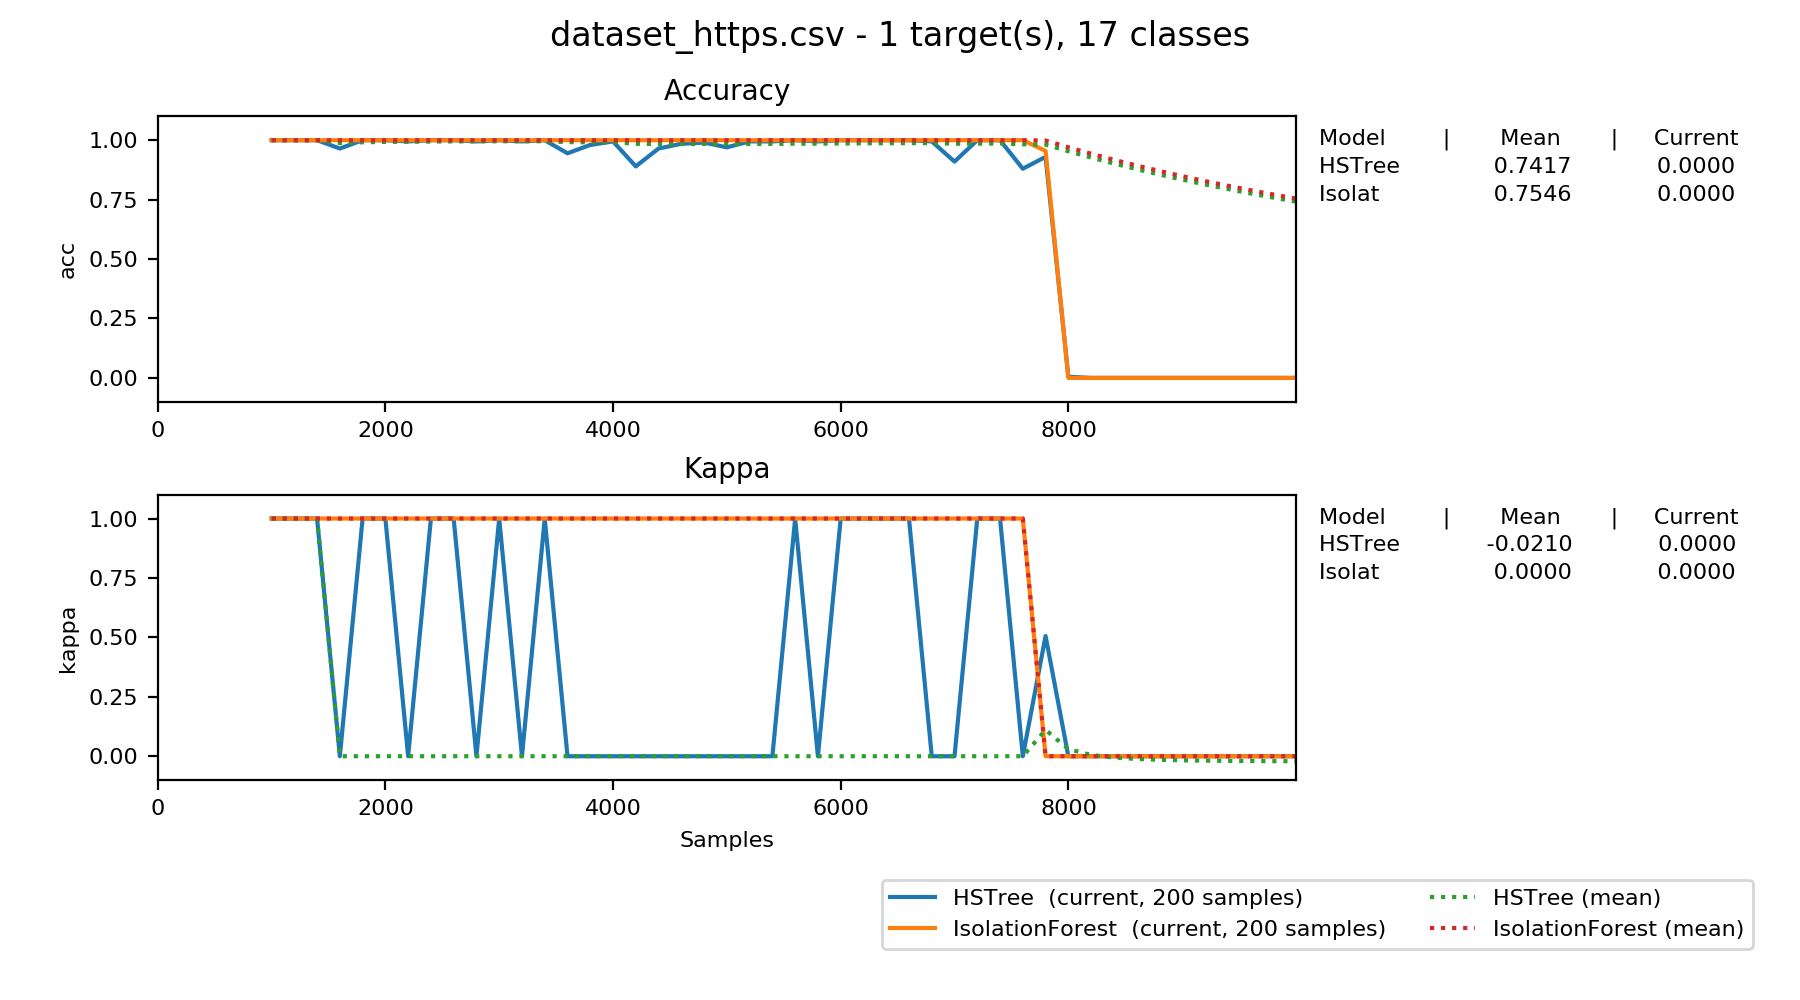

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 1000 sample(s).
Update
Evaluating...
 ##------------------ [10%] [28.42s]Update
 ###----------------- [15%] [82.19s]Update
 ######-------------- [30%] [229.76s]Update
 #######------------- [35%] [280.90s]Update
 ########------------ [40%] [366.48s]Update
Update
 ###############----- [75%] [1170.76s]Update
Update
Update
 ################---- [80%] [1266.23s]Update
Update
Update
Update
Update
 #################--- [85%] [1288.30s]Update
Update
Update
Update
Update
 ##################-- [90%] [1308.20s]Update
Update
Update
Update
Update
 ###################- [95%] [1324.86s]Update
Update
Update
Update
Update
 #################### [100%] [1343.39s]
Processed samples: 10000
Mean performance:
HSTree - Accuracy     : 0.7417
HSTree - Kappa        : -0.0210
IsolationForest - Accuracy     : 0.7546
IsolationForest - Kappa        : 0.0000


[HalfSpaceTrees(anomaly_threshold=0.9, depth=15, n_estimators=50, n_features=4,
                random_state=5, size_limit=10.0, window_size=100),
 IsolationForestStream(anomaly_threshold=0.9, drift_threshold=0.5,
                       n_estimators=50, n_wait=None, random_state=None,
                       window_size=100)]

In [0]:
%matplotlib notebook
import numpy as np
import pandas as pd
from skmultiflow.anomaly_detection import HalfSpaceTrees
from skmultiflow.data.file_stream import FileStream
from skmultiflow.data.data_stream import DataStream
from skmultiflow.data.file_stream import FileStream
from matplotlib import pyplot as plt
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from skmultiflow.trees import HoeffdingTree
from skmultiflow.evaluation.evaluate_prequential import EvaluatePrequential
from skmultiflow.lazy.knn_adwin import KNNAdwin, KNN
from sklearn.linear_model.stochastic_gradient import SGDClassifier
from skmultiflow.data.file_stream import FileStream
import matplotlib as plt
from skmultiflow.data import SEAGenerator
plt.interactive(True)

# 1. Create a stream

#stream = FileStream('/Users/zhansaya/Downloads/dataset_https.csv', n_targets=1, target_idx=-1)
# 2. Prepare for use
stream.prepare_for_use()
# 2. Instantiate the HoeffdingTree classifier
h = [HalfSpaceTrees(
    n_features=stream.n_features, 
    window_size=100, 
    n_estimators=50, 
    size_limit=0.1*100, 
    anomaly_threshold=0.90,
    depth=15, 
    random_state=5),
     IsolationForestStream(
    window_size=100, n_estimators=50, anomaly_threshold=0.9, drift_threshold=0.5, random_state=None)
    ]

# 3. Setup the evaluator

evaluator = EvaluatePrequential(pretrain_size=1000, max_samples=10000, show_plot=True, 
                                metrics=['accuracy', 'kappa'], 
                                batch_size=1)
# 4. Run
evaluator.evaluate(stream=stream, model=h, model_names=['HSTree','IsolationForest'])




## 3.2 Experiment 3 in the slides : 10000 samples, 500 window_size, 50 estimators

In [0]:
%matplotlib notebook
import numpy as np
import pandas as pd
from skmultiflow.anomaly_detection import HalfSpaceTrees
from skmultiflow.data.file_stream import FileStream
from skmultiflow.data.data_stream import DataStream
from skmultiflow.data.file_stream import FileStream
from matplotlib import pyplot as plt
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from skmultiflow.trees import HoeffdingTree
from skmultiflow.evaluation.evaluate_prequential import EvaluatePrequential
from skmultiflow.lazy.knn_adwin import KNNAdwin, KNN
from sklearn.linear_model.stochastic_gradient import SGDClassifier
from skmultiflow.data.file_stream import FileStream
import matplotlib as plt
from skmultiflow.data import SEAGenerator
plt.interactive(True)

# 1. Create a stream
## Put the path or real dataset or strem generator
#stream = FileStream('/Users/zhansaya/Downloads/dataset_https.csv', n_targets=1, target_idx=-1)
stream = stream = SEAGenerator(classification_function=0, noise_percentage=0.7, random_state=1)

# 2. Prepare for use
stream.prepare_for_use()
# 2. Instantiate the HoeffdingTree classifier
h = [HalfSpaceTrees(
    n_features=stream.n_features, 
    window_size=500, 
    n_estimators=50, 
    size_limit=0.1*100, 
    anomaly_threshold=0.5,
    depth=15, 
    random_state=5),
     IsolationForestStream(
    window_size=500, n_estimators=50, anomaly_threshold=0.5, drift_threshold=0.5, random_state=None)
    ]

# 3. Setup the evaluator

evaluator = EvaluatePrequential(pretrain_size=1000, max_samples=10000, show_plot=True, 
                                metrics=['accuracy', 'kappa'], 
                                batch_size=1)
# 4. Run
evaluator.evaluate(stream=stream, model=h, model_names=['HSTree','IsolationForest'])





<IPython.core.display.Javascript object>

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 1000 sample(s).
Evaluating...
 ##------------------ [10%] [15.96s]
Processed samples: 1079
Mean performance:
HSTree - Accuracy     : 0.4000
HSTree - Kappa        : -0.3636
IsolationForest - Accuracy     : 0.6000
IsolationForest - Kappa        : 0.0000


[HalfSpaceTrees(anomaly_threshold=0.5, depth=15, n_estimators=50, n_features=3,
                random_state=5, size_limit=10.0, window_size=500),
 IsolationForestStream(anomaly_threshold=0.5, drift_threshold=0.5,
                       n_estimators=50, random_state=None, window_size=500)]